## **1. MLP + Tensorboard**
Load dataset and set Tensorboard

In [0]:
# import shutil
# shutil.rmtree('runs')

In [0]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
%tensorboard --logdir runs

writer = SummaryWriter('runs/fashion_mnist_experiment_1')

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Visualize the samples of the train data

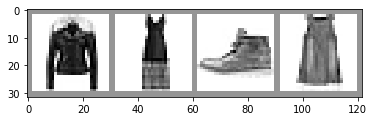

In [0]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

Define the network structure and forward pass

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 84)
        self.fc4 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net().to(device)

Define the loss and the optimizer for training the network 

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

### **Train function (practice #1)**
- Train loop
- Log learning statistics on Tensorboard
- Print learning statistics
- Log some images and prediction results on Tensorboard 


In [0]:
def train(trainloader, net, max_epochs):
  running_loss = 0.0
  running_acc = 0.0
  for epoch in range(max_epochs): 
      for i, data in enumerate(trainloader, 0):

          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          _, pred = torch.max(outputs, 1)
          prob = F.softmax(outputs, dim=1)
          
          acc = (pred==labels).sum()/labels.size(0)

          running_loss += loss.item()
          running_acc += acc.item()
          if i % 1000 == 999:    # every 1000 mini-batches...
              # ...log the running loss
              print(f'[Epoch {epoch} ({i}/{len(trainloader)})] '\
                    f'training loss : {running_loss/1000:.4f}, '\
                    f'training acc : {running_acc/1000*100} %')
              writer.add_scalar('training loss',
                              running_loss / 1000,
                              epoch * len(trainloader) + i)
              writer.add_scalar('training acc',
                              running_loss / 1000,
                              epoch * len(trainloader) + i)
              
              fig = plt.figure(figsize=(48,12))
              for idx in range(4):
                  ax = fig.add_subplot(1,4, idx+1, xticks=[],yticks=[])
                  matplotlib_imshow(inputs[idx].cpu(), one_channel=True)
                  

                  ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
                      classes[pred[idx]],
                      prob[idx][pred[idx]] * 100.0,
                      classes[labels[idx]]),
                      color=("green" if pred[idx]==labels[idx].item() else "red"))

              writer.add_figure('predictions vs. actuals',
                                fig,
                                global_step=epoch * len(trainloader) + i)
              running_loss = 0.0
              running_acc = 0.0
  print('Finished Training')

In [0]:
train(trainloader, net,1)

[Epoch 0 (999/15000)] training loss : 1.4219, training acc : 8.9 %
[Epoch 0 (1999/15000)] training loss : 0.7127, training acc : 27.400000000000002 %
[Epoch 0 (2999/15000)] training loss : 0.6185, training acc : 35.5 %
[Epoch 0 (3999/15000)] training loss : 0.5789, training acc : 38.3 %
[Epoch 0 (4999/15000)] training loss : 0.5562, training acc : 38.0 %
[Epoch 0 (5999/15000)] training loss : 0.5060, training acc : 42.199999999999996 %
[Epoch 0 (6999/15000)] training loss : 0.5077, training acc : 42.9 %
[Epoch 0 (7999/15000)] training loss : 0.4901, training acc : 45.2 %
[Epoch 0 (8999/15000)] training loss : 0.4791, training acc : 46.1 %
[Epoch 0 (9999/15000)] training loss : 0.4701, training acc : 48.9 %
[Epoch 0 (10999/15000)] training loss : 0.4637, training acc : 47.3 %
[Epoch 0 (11999/15000)] training loss : 0.4461, training acc : 50.9 %
[Epoch 0 (12999/15000)] training loss : 0.4439, training acc : 48.9 %
[Epoch 0 (13999/15000)] training loss : 0.4628, training acc : 48.3 %
[Epo

### **Test function (practice #2)**
- get the input
- forward pass
- compute loss and accuracy

In [0]:
def test(testloader, net):
  running_loss = 0.0
  running_acc = 0.0
  for i, data in enumerate(testloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data[0].to(device), data[1].to(device)

      # forward + backward + optimize
      outputs = net(inputs) 
      loss = criterion(outputs, labels)
      _, pred = torch.max(outputs, 1)
      acc = (pred==labels).sum()/labels.size(0)

      running_loss += loss.item()
      running_acc += acc.item()
    
  print(f'test loss : {running_loss/len(testloader):.4f}, test acc : {running_acc/len(testloader)*100} %')


In [0]:
test(testloader, net)

test loss : 0.4446, test acc : 49.84 %
